In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log
from dsb2018 import Dsb2018Dataset


%matplotlib inline

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Root directory of the project
ROOT_DIR = os.getcwd()

/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "dsb2018_logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Size of train data:603
Size of val data:67


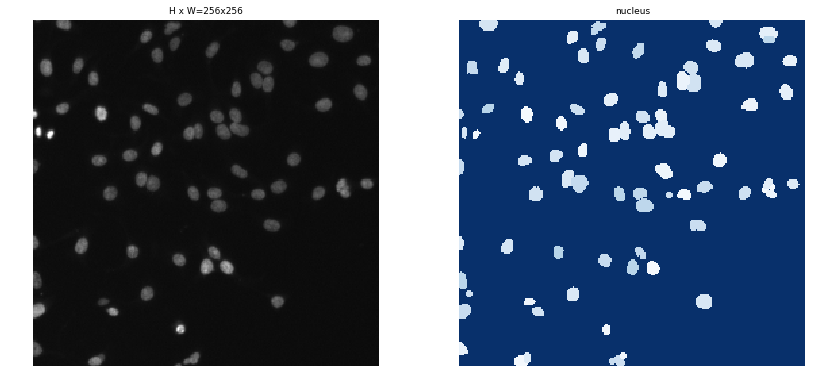

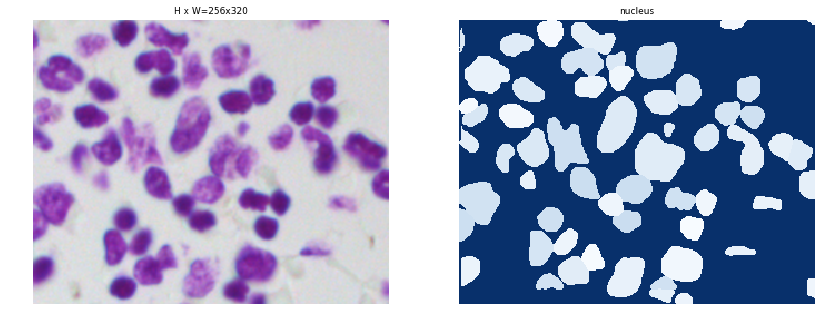

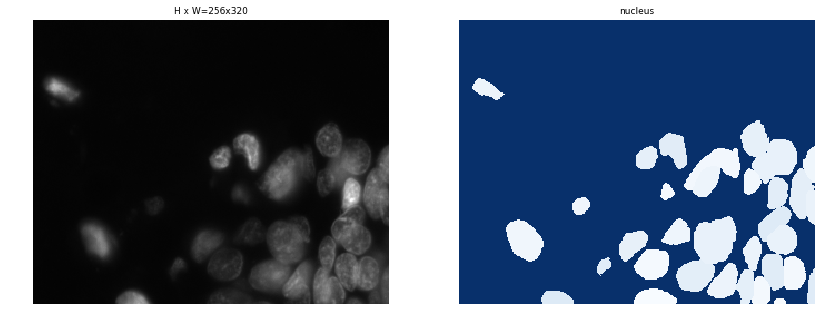

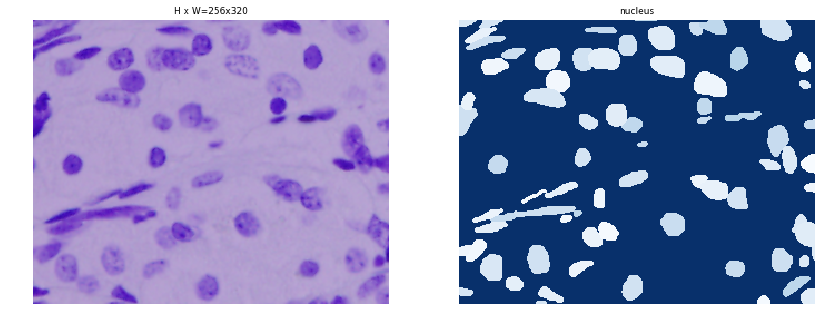

In [3]:
# Training dataset
train_data = Dsb2018Dataset()
train_data.load_dsb2018('../DSB2018')
train_data.prepare()

val_data = Dsb2018Dataset()
val_data.load_dsb2018('../DSB2018', is_trainset=False)
val_data.prepare()
print("Size of train data:{}".format(len(train_data.image_ids)))
print("Size of val data:{}".format(len(val_data.image_ids)))


#Load and display random samples
image_ids = np.random.choice(train_data.image_ids, 2)
for image_id in image_ids:
    image = train_data.load_image(image_id)
    mask, class_ids = train_data.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_data.class_names, limit=1)
    
    
#Load and display random samples
image_ids = np.random.choice(val_data.image_ids, 2)
for image_id in image_ids:
    image = val_data.load_image(image_id)
    mask, class_ids = val_data.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, val_data.class_names, limit=1)


In [4]:
class Dsb2018Config(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "DSB2018"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    USE_MINI_MASK = True
    
    #MINI_MASK_SHAPE = (112, 112)  # (height, width) of the mini-mask


    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64,128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 220
    
    DETECTION_MAX_INSTANCES = 220

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 152

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 18
    
    DETECTION_MIN_CONFIDENCE = 0.65

config = Dsb2018Config()

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(train_data, val_data,
            learning_rate=config.LEARNING_RATE,
            epochs=400,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/keven/data_science_bowl_2018/Mask_RCNN/dsb2018_logs/dsb201820180221T0053/mask_rcnn_dsb2018_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

/home/keven/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/400
152/152 [==============================] - 314s 2s/step - loss: 0.7189 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.2361 - mrcnn_class_loss: 0.1289 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.2061 - val_loss: 0.7685 - val_rpn_class_loss: 0.0205 - val_rpn_bbox_loss: 0.2503 - val_mrcnn_class_loss: 0.1263 - val_mrcnn_bbox_loss: 0.1430 - val_mrcnn_mask_loss: 0.2284
Epoch 40/400
152/152 [==============================] - 283s 2s/step - loss: 0.6219 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1865 - mrcnn_class_loss: 0.1165 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1967 - val_loss: 0.7124 - val_rpn_class_loss: 0.0174 - val_rpn_bbox_loss: 0.2385 - val_mrcnn_class_loss: 0.1453 - val_mrcnn_bbox_loss: 0.1211 - val_mrcnn_mask_loss: 0.1901
Epoch 76/400
152/152 [==============================] - 309s 2s/step - loss: 0.6147 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1806 - mrcnn_class_loss: 0.1176 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1955 - val_loss: 0.7609 - val_rpn_cl

In [12]:
import scipy.misc
        
import json
from skimage.io import imread, imshow, imread_collection, concatenate_images
import matplotlib.pyplot as plt
from utils import resize_image, resize_mask

class InferenceConfig(Dsb2018Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()[1]
model_path = '/home/keven/data_science_bowl_2018/Mask_RCNN/dsb2018_logs/dsb201820180221T0053/mask_rcnn_dsb2018_0092.h5'
print(model_path)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

def unpad(img, pad):
    y,x = img.shape
    top = pad[0][0]
    bottom = pad[0][1]
    left = pad[1][0]
    right = pad[1][1]
    
    startx = left
    endx = x-right
    starty = top
    endy = y-bottom
        
    return img[starty:endy,startx:endx]

def unpad3d(img, pad):
    y,x, _ = img.shape
    top = pad[0][0]
    bottom = pad[0][1]
    left = pad[1][0]
    right = pad[1][1]
    
    startx = left
    endx = x-right
    starty = top
    endy = y-bottom
        
    return img[starty:endy,startx:endx, :]


def revert_size(image, origin_size):
    result = scipy.misc.imresize(
            image,(origin_size[0],origin_size[1]))
    return result
    
def revert_size3d(image, origin_size):
    return scipy.misc.imresize(
            image, (origin_size[0], origin_size[1]))

def revert_resizing_3d(img, origin_size, padding):
    unpadding = unpad3d(img, padding)
    return revert_size3d(unpadding, origin_size)

def revert_resizing(img, origin_size, padding):
    unpadding = unpad(img, padding)
    try:
        return revert_size(unpadding, origin_size)
    except ValueError:
        print("error img, shape:{}, unpadding shape:{}, scale:{}, padding:{}"
              .format(img.shape, unpadding.shape, scale, padding))

def load_testset(pathname):
    dictionaries = []
    with open(pathname) as data:
        dictionaries = json.load(data)
    return dictionaries

base_dir = '../DSB2018'

test_set = load_testset(os.path.join(base_dir, 'test.json'))

/home/keven/data_science_bowl_2018/Mask_RCNN/dsb2018_logs/dsb201820180221T0053/mask_rcnn_dsb2018_0092.h5
Loading weights from  /home/keven/data_science_bowl_2018/Mask_RCNN/dsb2018_logs/dsb201820180221T0053/mask_rcnn_dsb2018_0092.h5


original_image           shape: (512, 512, 3)         min:   10.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max:  512.00000
gt_class_id              shape: (47,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (47, 4)               min:    0.00000  max:  512.00000
gt_mask                  shape: (512, 512, 47)        min:    0.00000  max:  255.00000


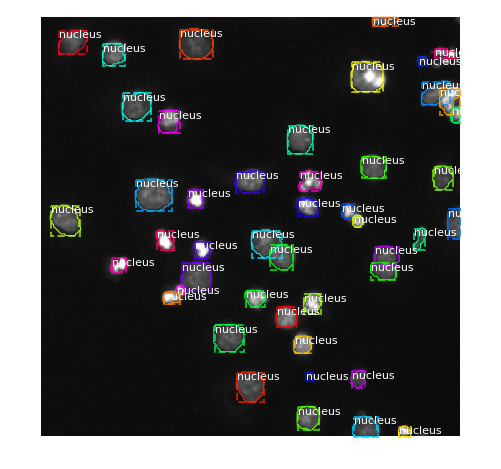

Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


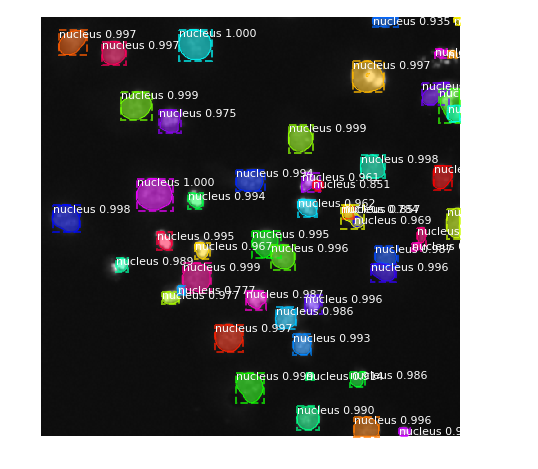

In [6]:
# Test on a random train image
image_id = random.choice(train_data.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(train_data, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_data.class_names, figsize=(8, 8))

# mask, class_ids = train_data.load_mask(image_id)
# visualize.display_top_masks(original_image, mask, class_ids, train_data.class_names, limit=1)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            train_data.class_names, r['scores'], ax=get_ax())

original_image           shape: (512, 512, 3)         min:    4.00000  max:   42.00000
image_meta               shape: (10,)                 min:    0.00000  max:  512.00000
gt_class_id              shape: (20,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (20, 4)               min:    0.00000  max:  512.00000
gt_mask                  shape: (512, 512, 20)        min:    0.00000  max:  255.00000
img size:(512, 512, 3)
mask size:(512, 512, 20)


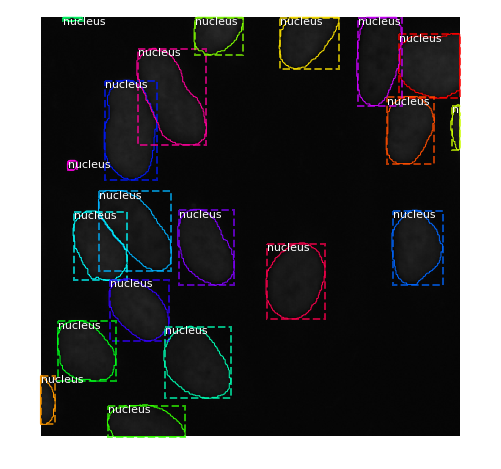

Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:   42.00000
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  -61.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


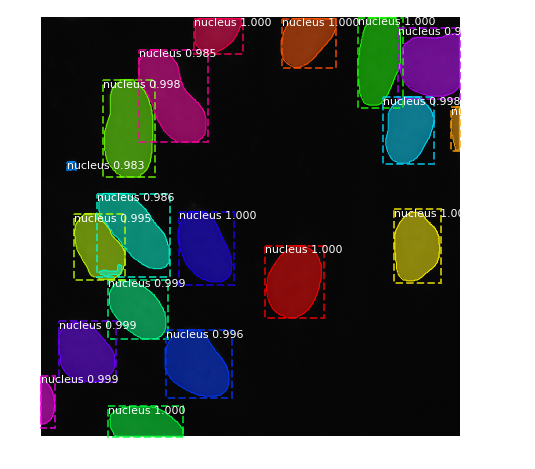

In [7]:
# Test on a random validation image
image_id = random.choice(val_data.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(val_data, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

print("img size:{}".format(original_image.shape))
print("mask size:{}".format(gt_mask.shape))

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            val_data.class_names, figsize=(8, 8))


results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            val_data.class_names, r['scores'], ax=get_ax())



55
{'image': {'checksum': '60e58d0b01c10ce966f805e8ef879c09', 'pathname': '505bc0a3928d8aef5ce441c5a611fdd32e1e8eccdc15cc3a52b88030acb50f81.png', 'shape': {'r': 512, 'c': 640, 'channels': 3}}, 'objects': []}
original shape:(512, 640, 3)
resized shape:(512, 512, 3), scale:0.8, padding:[(51, 51), (0, 0), (0, 0)]


/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


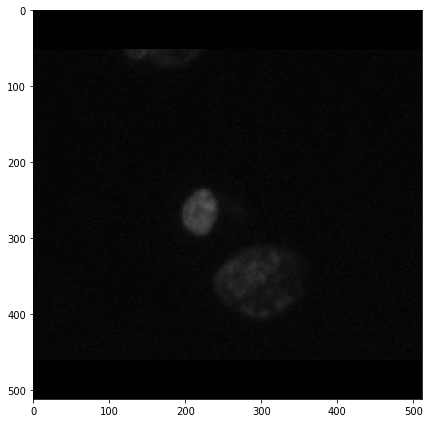

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:   97.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   -6.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


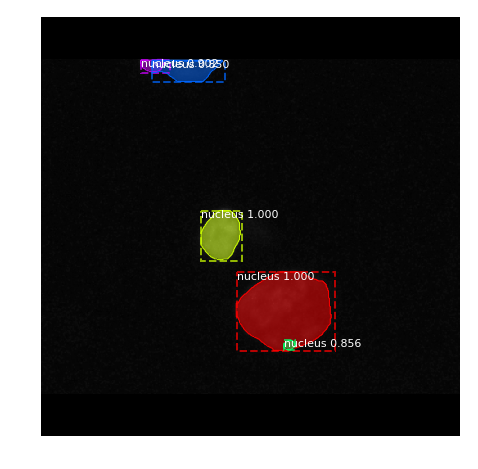

mask shape:(512, 512, 1)
(512, 410, 1)


/home/keven/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [6]:
# Test on a random test image

i = random.randint(0, len(test_set)-1)
print(i)
test = test_set[10]
print(test)
test_img = imread(os.path.join(base_dir, 'images', test['image']['pathname']))
print("original shape:{}".format(test_img.shape))
test_img,_, scale,padding = resize_image(test_img, min_dim=512,max_dim=512, padding=True)
print("resized shape:{}, scale:{}, padding:{}".format(test_img.shape,scale, padding))
plt.figure(figsize=(6,6))
imshow(test_img)
plt.show()

results = model.detect([test_img], verbose=1)
r = results[0]
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                            train_data.class_names, r['scores'], ax=get_ax())
first_mask = r['masks'][:,:,0]
first_mask = np.expand_dims(first_mask, axis=2)
print('mask shape:{}'.format(first_mask.shape))
print(resize_mask(first_mask, scale, padding).shape)

In [9]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(val_data.image_ids, 65)
APs = []
for image_id in val_data.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(val_data, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

/home/keven/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


mAP:  0.8356446739157355


origin_size:(256, 256, 3)
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  121.00000
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:   17.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000
(512, 512, 11)


/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


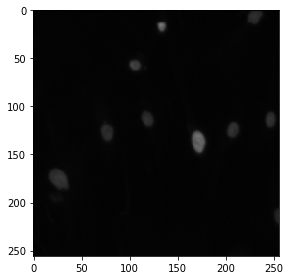

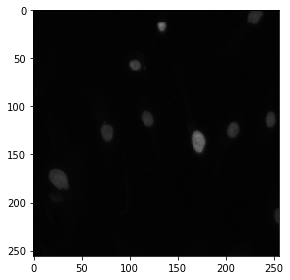

(512, 512)


/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [7]:
i = 0
# testing revert_resizing
img_data = test_set[i]
origin_img = imread(os.path.join(base_dir, 'images', img_data['image']['pathname']))
origin_size = origin_img.shape
print("origin_size:{}".format(origin_size))
resized_img,_, scale,padding = resize_image(origin_img, min_dim=512,max_dim=512, padding=True)

results = model.detect([resized_img], verbose=1)
masks = results[0]['masks']


revert_img = revert_resizing_3d(resized_img, origin_size, padding)

assert(revert_img.shape == origin_img.shape)

print(masks.shape)
imshow(revert_img)
plt.show()

imshow(origin_img)
plt.show()
print(masks[:,:,0].shape)


for i in range(masks.shape[-1]):
    mask = masks[:,:, i]
    reverted = revert_resizing(mask, origin_size, padding)
        
        
# for i in range(masks.shape[-1]):
#     print(masks[:,:,i].shape)
#     print(revert_resizing(masks[:,:,i], scale, padding).shape)
#     imshow(np.squeeze(masks[:,:,i]))
#     plt.show()

origin_size:(512, 640, 3)
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  138.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   34.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


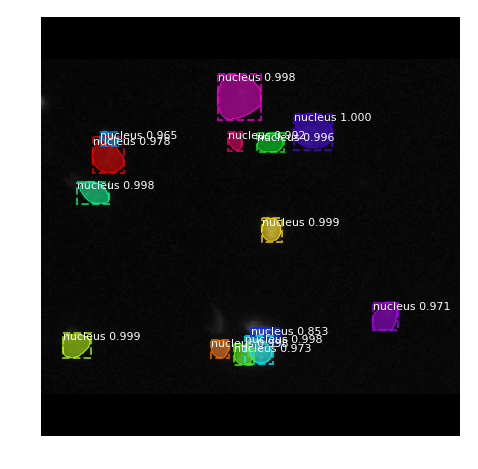

/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/keven/miniconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data 

14


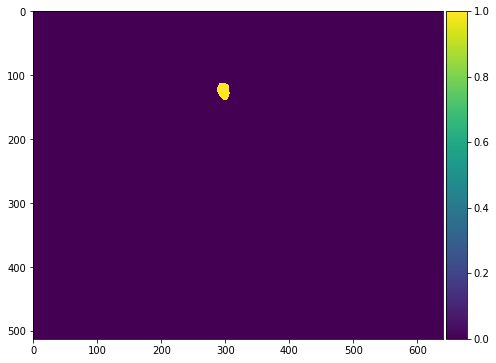

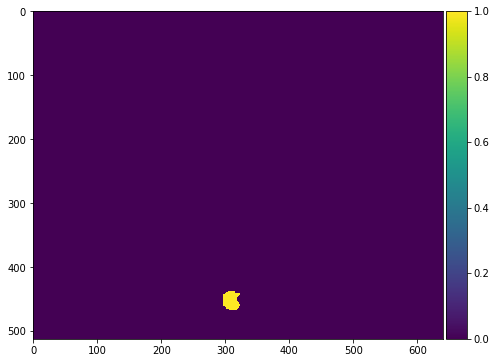

(array([], dtype=int64), array([], dtype=int64))


In [11]:
# debug image
i = 2
# testing revert_resizing
img_data = test_set[i]
origin_img = imread(os.path.join(base_dir, 'images', img_data['image']['pathname']))
origin_size = origin_img.shape
print("origin_size:{}".format(origin_size))
resized_img,_, scale,padding = resize_image(origin_img, min_dim=512,max_dim=512, padding=True)

results = model.detect([resized_img], verbose=1)
masks = results[0]['masks']
r = results[0]
visualize.display_instances(resized_img, r['rois'], r['masks'], r['class_ids'], 
                            train_data.class_names, r['scores'], ax=get_ax())



revert_img = revert_resizing_3d(resized_img, origin_size, padding)

assert(revert_img.shape == origin_img.shape)

reverted_masks = []
for i in range(masks.shape[-1]):
    mask = masks[:,:, i]
    reverted = revert_resizing(mask, origin_size, padding)
    reverted_masks.append(reverted)


# inter = reverted_masks[2]*reverted_masks[5]
# print(np.nonzero(inter))



print(len(reverted_masks))
plt.figure(figsize=(7,7))
imshow(np.squeeze(reverted_masks[8]))
plt.show()
plt.figure(figsize=(7,7))
imshow(np.squeeze(reverted_masks[10]))
plt.show()

inter = reverted_masks[8]*reverted_masks[10]
print(np.nonzero(inter))
row, col = np.nonzero(inter)
if len(row)>0:
    reverted_masks[8][row, col] = 0
# for i in range(len(reverted_masks)):
#     for j in range(i+1,len(reverted_masks)):
#         print("i:{}, j:{}".format(i,j))
#         inter = reverted_masks[i]*reverted_masks[j]
#         assert(len(np.nonzero(inter)[0]) == 0)


In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [13]:
import warnings
warnings.filterwarnings('ignore')


# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# convert single mask shape (h,w) into a list, 1: foreground, 0: background
def rle_encoding(x, total_pixel):
#     total = x.T.flatten().shape[0]
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b >= (total_pixel-1):
            continue
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def single_image(test):
    lines = []
    image_id =  test['image']['pathname']
    origin_img = imread(os.path.join(base_dir, 'images', test['image']['pathname']))
#     print("origin image shape:{}".format(origin_img.shape))
    resized_img,_, scale,padding = resize_image(origin_img, min_dim=512,max_dim=512, padding=True)
#     print("handing img:{}, scale:{}, padding:{}".format(image_id, scale, padding))


    results = model.detect([resized_img], verbose=0)
    scores = results[0]['scores']
    masks = results[0]['masks']
#     visualize.display_instances(resized_img, r['rois'], r['masks'], r['class_ids'], 
#                             train_data.class_names, r['scores'], ax=get_ax())
    s0 = 1
    for s in scores:
        if s< s0:
            s0 = s
    print("{} masks detected, lowest score is {}".format(masks.shape[-1], s0))
    
    reverted_masks = []
    for i in range(masks.shape[-1]):
        mask = masks[:,:,i]
        reverted_mask = revert_resizing(mask, origin_img.shape, padding)
        assert(reverted_mask.shape[0] == origin_img.shape[0])
        assert(reverted_mask.shape[1] == origin_img.shape[1])
        reverted_masks.append(reverted_mask)
    
    for i in range(len(reverted_masks)):
        for j in range(i+1, len(reverted_masks)):
            interaction = reverted_masks[i]*reverted_masks[j]
            row, col = np.nonzero(interaction)
            if len(row)>0:
#                 print("before, {} pixels overlapping between mask {} and {}".format(len(row), i, j))
                reverted_masks[i][row, col] = 0
#                 print("after, {} pixels overlapping".format(len(np.nonzero(reverted_masks[i]*reverted_masks[j])[0])))
                
    
    for i in range(len(reverted_masks)):
        assert(reverted_masks[i].shape[0] == origin_img.shape[0])
        assert(reverted_masks[i].shape[1] == origin_img.shape[1])
        rle = rle_encoding(reverted_masks[i], origin_img.shape[0]*origin_img.shape[1])
        lines.append("{},{}".format(image_id[:-4],' '.join(map(str, rle))))
    return lines

base_dir = '../DSB2018'
test_set = load_testset(os.path.join(base_dir, 'test.json'))
print("in total {} images to predict".format(len(test_set)))
with open('sub134_3.csv', 'w') as f: 
    f.write('ImageId,EncodedPixels\n')
    for i, test in enumerate(test_set):
        lines = single_image(test)
        for line in lines:
            f.write(line)
            f.write('\n')
    
print("submision file completed!")

in total 65 images to predict
12 masks detected, lowest score is 0.6777924299240112
53 masks detected, lowest score is 0.6553987860679626
14 masks detected, lowest score is 0.861355721950531
27 masks detected, lowest score is 0.7868253588676453
18 masks detected, lowest score is 0.676048994064331
58 masks detected, lowest score is 0.7051103115081787
45 masks detected, lowest score is 0.6594347357749939
8 masks detected, lowest score is 0.7586772441864014
5 masks detected, lowest score is 0.9865128993988037
10 masks detected, lowest score is 0.9734206199645996
5 masks detected, lowest score is 0.8529516458511353
60 masks detected, lowest score is 0.6573002934455872
20 masks detected, lowest score is 0.6608290076255798
43 masks detected, lowest score is 0.7676544189453125
54 masks detected, lowest score is 0.7372542023658752
17 masks detected, lowest score is 0.7163057923316956
61 masks detected, lowest score is 0.687437117099762
17 masks detected, lowest score is 0.7586126327514648
34 m

In [14]:
print(len(test_set))

65


In [12]:
import numpy as np
a = np.array([[1,1,0], [0,0,0], [1,0,0]])
b = np.array([[0,0,0], [0,0,0], [0,0,0]])
print(a*b)
len(np.nonzero(a*b)[0]) == 0

[[0 0 0]
 [0 0 0]
 [0 0 0]]


True

In [21]:
for i in range(1, 10):
    print(i)

1
2
3
4
5
6
7
8
9
